# Specialty Project

## Overview

The historical physician dictionary is incomplete regarding the specialty and service. There are many entries that do not have a specialty defined, or it is defined as "Unknown". Since the data are historical it isn't possible to update the specialty from our clients. There is also historical procedure data for these physicians. The goal of this project is to determine if it is possible to build a model to identify the specialty for these unknowns.

The procedure data is sparse due to the use of the raw procedure codes. Procedure codes may be categorized (CPT, HCPCS, ICD) as well as AHRQ CCS and CMS HCC coding. For this exploratory project this coding will not be utilized.

### Exploratory Data Analysis

The EDA process involves loading the data files and verifying that they are applicable to the question. Some of the steps are:

* Check for missing data.
* Check the top and bottom of the data to ensure the files were read correctly.
* Examine the distribution of the specialties and identify the physicians with an unknown specialty.
* Select a specialty to analyze and model.
* Check the frequency of the most prevalent procedure codes for the selected specialty against the physicians with an unknown specialty.
* Restructure the data to be applicable for modeling.
* Examine the frequency and patient counts for the procedure codes.

### Model Building and Review

The model building process includes:

* Splitting the data into "specialty known" (**`df_not_unknown`**) and "specialty unknown" (**`df_unknown`**) data sets.
* Splitting the "specialty known" data into training, validation, and test data sets; **`df_train`**, **`df_valid`**, and **`df_test`**, respectively.
* Scaling the data. The data are sparse and the units are the same (patient count), but the 0's may cause issues with PCA and gradient descent so I will scale with the sklearn StandardScaler.
* Examining the dimensionality and investigating feature selection.
* Fitting classification models.
* Use the validation data to examine the fit and tune hyperparameters. 
* Examine key predictors.
* Select a model to further turn prior to using the test data.
* Validate the selected model using the test data.
* Generate predictions for the selected specialty using the "specialty unknown" data set.

## Import Libraries and Read Physician Specialty Data

The numpy, pandas, matplotlib, and sklearn libraries are utilized for this project. The sklearn imports are performed later in the notebook.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import itertools
import sys
from IPython.display import display, HTML
from os.path import isfile
%matplotlib inline

if not isfile("physicians.csv"):
   sys.exit("The working directory must be the location of the data files.")


### Exploratory Data Analysis

Read the file with the physician specialties then display the top and bottom rows to ensure the data were read correctly.

In [2]:
# read the physician and specialty data
df_phy = pd.read_csv("physicians.csv")

display(HTML(df_phy.head(5).to_html()))
display(HTML(df_phy.tail(5).to_html()))

,id,specialty
0,0,General Surgery
1,1,Unknown
2,2,Family Practice
3,3,Emergency Medicine
4,4,Plastic and Reconstructive Surgery


,id,specialty
36020,36020,Cardiology
36021,36021,Pathology
36022,36022,Thoracic Surgery
36023,36023,Ophthalmology
36024,36024,Unknown


Rename **`id`** to be **`physician_id`** (personal preference) and check for missing data.

In [3]:
# rename id to physician_id
df_phy.rename(index=str,columns={"id":"physician_id"},copy=False,inplace=True)
# check for missing data
print("Physician missing values = " + str(df_phy.isna().sum().sum()))

Physician missing values = 0


There are no missing values.  Now tabulate the specialties and examine the frequencies as well as the prevalence of "Unknown".

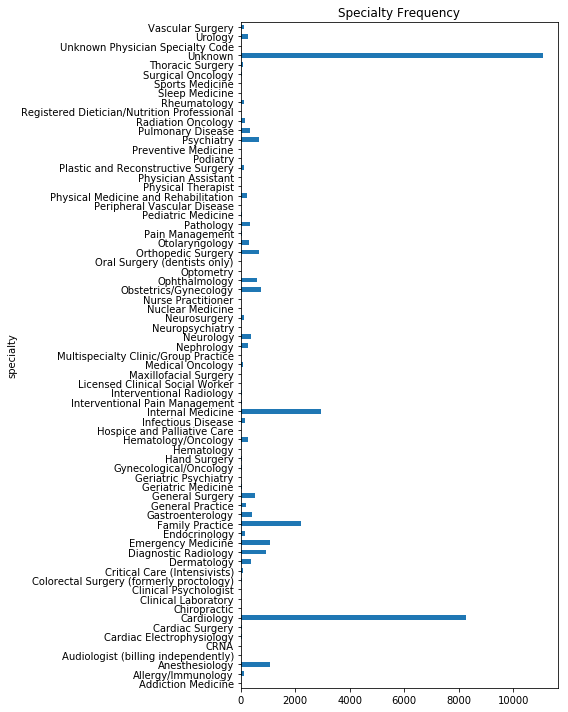

In [4]:
specialties = pd.crosstab(index=df_phy["specialty"],columns="count")

# view as a horizontal bar chart
specialties.plot.barh(legend=False,title="Specialty Frequency",figsize=(8,10))
plt.tight_layout()
plt.show()

There are 2 "Unknown" specialties; consider them the same for this exercise. Regenerate the plot excluding the unknown specialty.

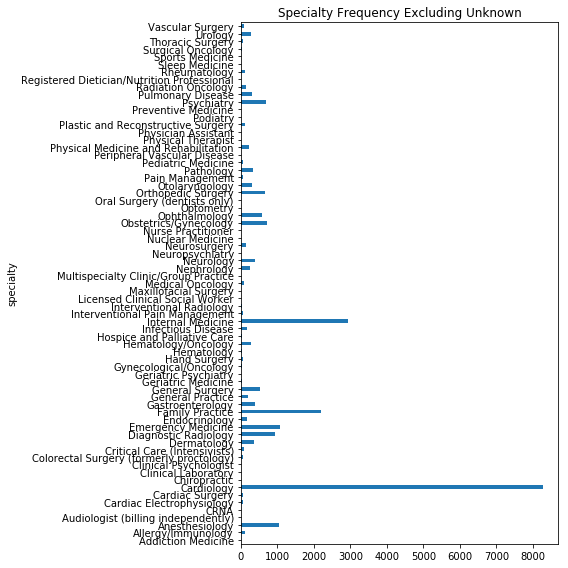

In [5]:
specialties[(specialties.index.str.startswith("Unknown") == False)].plot.barh(legend=False,
            title="Specialty Frequency Excluding Unknown",figsize=(8,8))
plt.tight_layout()
plt.show()

Many of the specialties have very few physicians. Check the quantiles of the frequency count.

In [61]:
print(specialties.quantile(q=(0.1,0.25,0.5,0.75,0.9)))

col_0  count
0.10     2.0
0.25     9.0
0.50    50.0
0.75   285.0
0.90   724.0


Regenerate the plot excluding specialties with counts below the median.

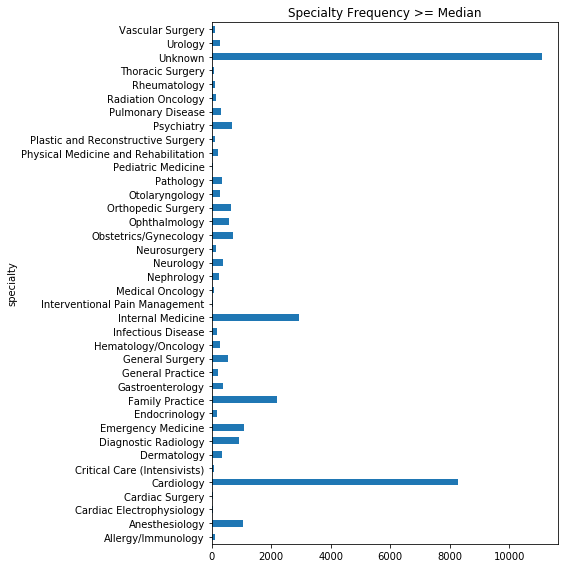

In [6]:
q50 = specialties.quantile(q=0.5)[0]
specialties[specialties['count'] >= q50].plot.barh(legend=False,
            title="Specialty Frequency >= Median",figsize=(8,8))
plt.tight_layout()
plt.show()

The "Cardiology" specialty is well represented. This will be the specialty selected for modeling for this project. Note that "Cardiac Surgery" and "Cardiac Electrophysiology" are related specialties but are not considered cardiologists. For example, a "Cardiologist" will send a patient to a "Cardiac Surgeon".

Next, create an outcome variable for Cardiology for classification and display the frequency.

In [8]:
df_phy['Cardiology'] = np.where(df_phy['specialty'] == "Cardiology", 1, 0)
pd.crosstab(df_phy['Cardiology'],'count')

col_0,count
Cardiology,
0,27751
1,8274


## Read the Procedure Records and Explore the Data

Next, read the file with the physician procedures, display the first and last 10 records, and check for missing values.

In [9]:
# read the procedure records
df_proc = pd.read_csv("procedures.csv")

display(HTML(df_proc.head(10).to_html()))
display(HTML(df_proc.tail(10).to_html()))

# check for missing data
print("Procedures missing values = " + str(df_proc.isna().sum().sum()))

,physician_id,procedure_code,procedure,number_of_patients
0,0,99202,"new_patient_office_or_other_outpatient_visit,_...",14
1,0,99203,"new_patient_office_or_other_outpatient_visit,_...",15
2,0,99205,"new_patient_office_or_other_outpatient_visit,_...",12
3,0,99212,established_patient_office_or_other_outpatient...,27
4,0,99213,established_patient_office_or_other_outpatient...,16
5,0,99221,"initial_hospital_inpatient_care,_typically_30_...",13
6,0,99232,"subsequent_hospital_inpatient_care,_typically_...",12
7,1,76942,ultrasonic_guidance_imaging_supervision_and_in...,14
8,2,99213,established_patient_office_or_other_outpatient...,34
9,2,99214,established_patient_office_or_other_outpatient...,17


,physician_id,procedure_code,procedure,number_of_patients
587764,36024,93000,routine_ekg_using_at_least_12_leads_including_...,11
587765,36024,99202,"new_patient_office_or_other_outpatient_visit,_...",33
587766,36024,99213,established_patient_office_or_other_outpatient...,133
587767,36024,99214,established_patient_office_or_other_outpatient...,29
587768,36024,G0008,administration_of_influenza_virus_vaccine,63
587769,36024,G0009,administration_of_pneumococcal_vaccine,29
587770,36024,G0402,initial_preventive_physical_examination;_face-...,11
587771,36024,G0403,"electrocardiogram,_routine_ecg_with_12_leads;_...",13
587772,36024,G0438,annual_wellness_visit;_includes_a_personalized...,14
587773,36024,G0439,"annual_wellness_visit,_includes_a_personalized...",45


Procedures missing values = 0


Excellent, no missing values! These appear to be CPT and HCPCS codes. Check the categories and frequency of the HCPCS codes.

In [10]:
print("There are " + 
      str(pd.crosstab(df_proc.loc[df_proc['procedure_code'].str.match("(^[A-Z])"),'procedure_code'],columns='count').shape[0]) +
      " unique HCPCS codes.")

# display the categories and counts (not unique)
display(HTML(pd.crosstab(df_proc['procedure_code'].str.extract("(^[A-Z])",expand=False),columns='count').to_html()))

There are 371 unique HCPCS codes.


col_0,count
procedure_code,
A,5114
E,2
G,20194
J,16188
L,8
M,9
P,30
Q,5092
S,7


There are a lot of HCPCS codes other than CPT. Next, verify that the most prevalent codes for "Cardiology" are also well represented for the "Unknown" specialty.

In [11]:
df_temp = df_phy[(df_phy['Cardiology'] == 1) |
   (df_phy['specialty'].str.startswith("Unknown"))].copy()
df_temp.loc[df_temp['specialty'].str.startswith("Unknown"),'specialty'] = "Unknown"
df_check = pd.merge(df_temp,df_proc,on='physician_id')
df_check = pd.crosstab(df_check['procedure_code'],df_check['specialty'])
df_check = df_check[(df_check['Cardiology'] > 0) & (df_check['Unknown'] > 0)]
df_check = df_check[df_check['Cardiology'] > df_check['Cardiology'].quantile(0.5)]
df_check.sort_values(by=['Cardiology'],ascending=False,inplace=True)
display(HTML("<p>This table has the top 25 Cardiology procedures and the corresponding frequency for the Unknown specialty.</p>"))
display(HTML(df_check.head(25).to_html()))

specialty,Cardiology,Unknown
procedure_code,,
93306,10383,4765
99214,8943,7862
99213,7263,7478
93000,6207,3568
99232,6165,4654
93010,5857,3017
99204,5763,4433
99223,5224,3797
78452,5158,2441


The procedure codes for Cardiology are well represented in the Unknown specialty. Now display as a percentage bar chart.

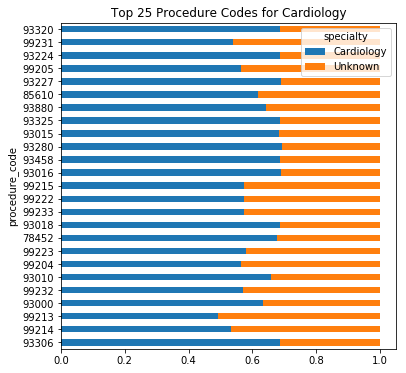

In [12]:
df_check['Total'] = df_check['Cardiology'] + df_check['Unknown']
df_check['Cardiology'] = df_check['Cardiology'] / df_check['Total']
df_check['Unknown'] = df_check['Unknown'] / df_check['Total']
df_check[['Cardiology','Unknown']].head(25).plot(kind='barh', stacked=True,
   figsize=(6,6),title="Top 25 Procedure Codes for Cardiology")
plt.show()
del(df_temp, df_check)

Restructure the data so that the procedure codes are columns, the records are physicians, and the values are patient counts. The resulting data frame will be sparse. Set the fill to be 0 to suppress missing values.

Note: This block of code may take a few minutes to run.

In [13]:
df_codes = df_proc.pivot_table(values='number_of_patients',index='physician_id',
                        columns='procedure_code',aggfunc=sum,fill_value=0)
df_codes = pd.DataFrame(df_codes.to_records())
df_codes = pd.merge(df_phy, df_codes, on='physician_id')
display(HTML(df_codes.iloc[1:5,list(range(0,12))].to_html()))

,physician_id,specialty,Cardiology,00100,00103,00104,00120,00140,00142,00144,00145,00160
1,1,Unknown,0,0,0,0,0,0,0,0,0,0
2,2,Family Practice,0,0,0,0,0,0,0,0,0,0
3,3,Emergency Medicine,0,0,0,0,0,0,0,0,0,0
4,4,Plastic and Reconstructive Surgery,0,0,0,0,0,0,0,0,0,0


Build a lookup table for the procedure codes and descriptions to aid in reviewing the results.

In [14]:
proc_lookup = df_proc[['procedure_code','procedure']].drop_duplicates()
proc_lookup = pd.DataFrame(proc_lookup['procedure'].values,
                index=proc_lookup['procedure_code'],columns=['procedure'],)
del(df_proc) # memory is tight so clean up when possible
display(HTML(proc_lookup.head(10).to_html()))

,procedure
procedure_code,
99202,"new_patient_office_or_other_outpatient_visit,_..."
99203,"new_patient_office_or_other_outpatient_visit,_..."
99205,"new_patient_office_or_other_outpatient_visit,_..."
99212,established_patient_office_or_other_outpatient...
99213,established_patient_office_or_other_outpatient...
99221,"initial_hospital_inpatient_care,_typically_30_..."
99232,"subsequent_hospital_inpatient_care,_typically_..."
76942,ultrasonic_guidance_imaging_supervision_and_in...
99214,established_patient_office_or_other_outpatient...


Review the restructured data prior to modeling checking the frequency of non-zero procedure codes and the patient count for each code.

First, compute the number of non-zero records and display the percentiles.

In [15]:
# check the number of non-zero records for each code without regard to patient count
codePhyFreq = np.count_nonzero(df_codes.iloc[:,list(range(3,df_codes.shape[1]))],axis=0)
print(np.percentile(codePhyFreq,q=(10,25,50,75,90)))

[  1.   2.  10.  59. 268.]


Not surprisingly, there are a number of procedure codes only used by a few physicians; the 1<sup>st</sup> quartile is 2. Next, check the total patient count for each code.

In [16]:
# check the patient count for each code
codePhySum = np.sum(df_codes.iloc[:,list(range(3,df_codes.shape[1]))],axis=0)
print(codePhySum.describe())

count    3.140000e+03
mean     1.614269e+04
std      1.626953e+05
min      1.100000e+01
25%      4.900000e+01
50%      2.905000e+02
75%      2.030750e+03
max      4.674697e+06
dtype: float64


Exclude codes that only represent a few physicians since there aren't enough to split into training, validation, and test data. Also, cross-validation will have all 0's for most folds. Rather than deleting, these codes will be rolled into another bucket.

In [17]:
q25 = np.percentile(codePhyFreq,q=25)
feature_names = df_codes.columns.get_values() # get a list of the names
feature_names = feature_names.tolist()
feature_names = feature_names[3:df_codes.shape[1]] # exclude physician_id, specialty, and Cardiology
drop_names = []
code_bucket = np.zeros(df_codes.shape[0])

for i in range(0,len(codePhyFreq)):
    if codePhyFreq[i] <= q25:
        drop_names.append(feature_names[i])
        code_bucket += df_codes[feature_names[i]]

print("Procedure codes rolled into another bucket = " + str(len(drop_names)))
df_codes.drop(columns=drop_names,axis=1,inplace=True)

Procedure codes rolled into another bucket = 852


In [18]:
print("Physicians with non-zero records in the bucket = " + str(np.count_nonzero(code_bucket)))
print("Maximum patient count for the bucket = " + str(np.amax(code_bucket)))

df_codes['code_bucket'] = code_bucket
del(code_bucket)

# update feature_names
feature_names = df_codes.columns.get_values() # get a list of the names
feature_names = feature_names.tolist()
feature_names = feature_names[3:df_codes.shape[1]]

Physicians with non-zero records in the bucket = 853
Maximum patient count for the bucket = 3337.0


### Model Building and Review

Split the records into a dataset for the "Unknown" specialty as well as the "Unknown Physician Specialty Code" (**`df_unknown`**) and a dataset for the known specialties (**`df_not_unknown`**).

In [19]:
df_not_unknown = df_codes[(df_codes.specialty.str.startswith("Unknown") == False)].copy()
df_unknown = df_codes[(df_codes.specialty.str.startswith("Unknown") == True)].copy()

Split **`df_not_unknown`** into training, validation, and data sets. The split will be 60%, 20%, 20%, respectively. The **random_state** parameter is specified for reproducibility.

In [20]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df_not_unknown,test_size=0.4,random_state=1102)
df_valid, df_test = train_test_split(df_test,test_size=0.5,random_state=1207)
del(df_not_unknown)  # no longer necessary

print("Training dimensions = " + str(df_train.shape))
print("Validation dimensions = " + str(df_valid.shape))
print("Test dimensions = " + str(df_test.shape))
print("Unknown specialty dimensions = " + str(df_unknown.shape))

Training dimensions = (14957, 2292)
Validation dimensions = (4986, 2292)
Test dimensions = (4986, 2292)
Unknown specialty dimensions = (11096, 2292)


Due to the very sparse data it is likely that there are columns in the training data that are all 0's. Identify and remove these columns and also remove them from the validation, test, and unknown data sets.

In [21]:
drop_names = [] 
for colName in feature_names:
    if df_train[colName].std()==0:
        drop_names.append(colName)
        
if len(drop_names) > 0:
   print("There were " + str(len(drop_names)) + " columns of 0's removed.")
   df_train.drop(columns=drop_names,axis=1,inplace=True)
   df_valid.drop(columns=drop_names,axis=1,inplace=True)
   df_test.drop(columns=drop_names,axis=1,inplace=True)
   df_unknown.drop(columns=drop_names,axis=1,inplace=True)
   # refresh the saved names
   feature_names = df_train.columns.get_values()
   feature_names = feature_names.tolist()
   feature_names = feature_names[3:df_train.shape[1]] # exclude physician_id, speciality, and Cardiology


There were 73 columns of 0's removed.


Confirm the dimensions of the data frames.

In [22]:
print("Training dimensions = " + str(df_train.shape))
print("Validation dimensions = " + str(df_valid.shape))
print("Test dimensions = " + str(df_test.shape))
print("Unknown specialty dimensions = " + str(df_unknown.shape))

Training dimensions = (14957, 2219)
Validation dimensions = (4986, 2219)
Test dimensions = (4986, 2219)
Unknown specialty dimensions = (11096, 2219)


It is also possible that there are duplicate features (different names, same data). However, since the values are based on patient count it is unlikely. Use feature frequency counts and patient totals to improve the performance of this check.

Note: This code may take a few minutes.

In [23]:
drop_names = []
dup_names = []
codePhySum = np.sum(df_train[feature_names],axis=0)
codePhyFreq = np.count_nonzero(df_train[feature_names],axis=0)
codePhyFreq = pd.Series(data=codePhyFreq,index=codePhySum.index)
drop_flag = np.zeros(len(codePhyFreq))

for i in range(0,len(codePhySum)):
   if drop_flag[i] > 0:
      continue
   for j in range(i+1,len(codePhySum)):
      if drop_flag[j] > 0:
         continue
      # use codePhyFreq and codePhySum to speed up processing
      if (codePhyFreq[i] == codePhyFreq[j]) and (codePhySum[i] == codePhySum[j]):
         if np.array_equiv(df_train.loc[:,feature_names[i]],df_train.loc[:,feature_names[j]]):
            drop_flag[j] = 1
            drop_names.append(feature_names[j])
            dup_names.append(feature_names[i])

if len(drop_names) > 0:
   print("There were " + str(len(drop_names)) + " columns of 0's.")
   dup_features = pd.DataFrame(data={'feature' : dup_names,
         'feature_desc' : proc_lookup.loc[dup_names,'procedure'].reset_index(drop=True),
         'dup': drop_names,
         'dup_desc' : proc_lookup.loc[drop_names,'procedure'].reset_index(drop=True)},
         index=None)
   display(HTML(dup_features.loc[:,['feature','feature_desc','dup','dup_desc']].to_html()))

There were 5 columns of 0's.


,feature,feature_desc,dup,dup_desc
0,20612,aspiration_and/or_injection_of_cysts,26040,"release_of_tissues_of_palm,_accessed_through_t..."
1,64581,incision_to_insert_sacral_nerve_neurostimulato...,64590,insertion_or_replacement_of_peripheral_or_gast...
2,76965,ultrasonic_guidance_for_administration_of_radi...,77778,"application_of_radiation_source,_complex"
3,80174,imipramine_level,80182,nortriptyline_level
4,81240,"gene_analysis_(prothrombin,_coagulation_factor...",81241,gene_analysis_(coagulation_factor_v)_leiden_va...


It would be best to have a clinician examine these codes and advise which to keep; however, for this initial project I will keep the first one found.

In [24]:
if len(drop_names) > 0:
   df_train.drop(columns=drop_names,axis=1,inplace=True)
   df_valid.drop(columns=drop_names,axis=1,inplace=True)
   df_test.drop(columns=drop_names,axis=1,inplace=True)
   df_unknown.drop(columns=drop_names,axis=1,inplace=True)
   # refresh the saved feature names
   feature_names = df_train.columns.get_values()
   feature_names = feature_names.tolist()
   feature_names = feature_names[3:df_train.shape[1]] # exclude physician_id, speciality, and Cardiology


Once again confirm the dimensions of the data frames.

In [25]:
print("Training dimensions = " + str(df_train.shape))
print("Validation dimensions = " + str(df_valid.shape))
print("Test dimensions = " + str(df_test.shape))
print("Unknown specialty dimensions = " + str(df_unknown.shape))

Training dimensions = (14957, 2214)
Validation dimensions = (4986, 2214)
Test dimensions = (4986, 2214)
Unknown specialty dimensions = (11096, 2214)


Scale the training data and apply the transfrom to the validation, test, and unknown data sets. For a sparse matrix of simple counts I prefer the MaxAbsScaler to preserve the 0's. The scaled features will be separate from the source data frame with a **`X`** suffix; e.g., df_trainX.

In [26]:
from sklearn.preprocessing import MaxAbsScaler
scaler = MaxAbsScaler()

X = scaler.fit_transform(df_train.iloc[:,list(range(3,df_train.shape[1]))])
df_trainX = pd.DataFrame(data=X,index=None,columns=feature_names,copy=True)

# apply the scale to the validation data
X = scaler.transform(df_valid.iloc[:,list(range(3,df_valid.shape[1]))])
df_validX = pd.DataFrame(data=X,index=None,columns=feature_names,copy=True)

# apply the scale to the test data
X = scaler.transform(df_test.iloc[:,list(range(3,df_test.shape[1]))])
df_testX = pd.DataFrame(data=X,index=None,columns=feature_names,copy=True)

# apply the scale to the unknown data
X = scaler.transform(df_unknown.iloc[:,list(range(3,df_unknown.shape[1]))])
df_unknownX = pd.DataFrame(data=X,index=None,columns=feature_names,copy=True)

The modeling techniques I will be using are:

* PCA
* Logistic regression with L1 penalty (Lasso)
* Random Forest
* Gradient Boosting

I will run a PCA and check the number of components and variance explained, and if promising I will use the transformed data in a random forest. 

When working with diagnosis and procedures codes I prefer to keep the original codes as features whenever possible since it allows clinical review of the coefficients, importance, etc. When available, I like to use classifications such as AHRQ CCS and CMS HCC to bundle low volume codes. 

I will start with a simple PCA on the training data and examine the percentage of explained variance for 100 components.

In [27]:
from sklearn.decomposition import PCA

pca = PCA(n_components=100)
pcafit = pca.fit(df_trainX)

print("Percentage of variance explained by 100 components = " + str(np.sum(pcafit.explained_variance_ratio_)*100))

Percentage of variance explained by 100 components = 50.381903001402236


That is disappointing. Try increasing the number of components to 500.

In [28]:
pca = PCA(n_components=500)
pcafit = pca.fit(df_trainX)

print("Percentage of variance explained by 500 components = " + str(np.sum(pcafit.explained_variance_ratio_)*100))

Percentage of variance explained by 500 components = 80.6307280291522


This isn't very promising. I'm going to move on to the Logistic Regression with a L1 penalty. I will use sklearn LogisticRegressionCV to search for the best lambda that maximizes accuracy. The grid size is 25 with a refit at the end to return the fit.  The **random_state** parameter is specified for reproducibility.

Note: The **n_jobs** parameter is set to 1 for my system. It may be increased or set to -1 based on the host system. This will likely require several minutes to complete.

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

init_clflr = LogisticRegression(penalty='l1',random_state=926)

param_grid = { 'C': [ 0.1, 0.25, 0.5, 0.75, 1, 2, 5 ] }
grid_clflr = GridSearchCV(init_clflr, param_grid, scoring='accuracy',cv=10,return_train_score=True, n_jobs=1)
grid_clflr.fit(df_trainX,df_train['Cardiology'])

# select the best estimator as measured by accuracy
clflr = grid_clflr.best_estimator_
lr_maxAccuracy = grid_clflr.best_score_

print("Logistic regression CV accuracy = %0.3f" % lr_maxAccuracy)
print("# coefficients = " + str(np.count_nonzero(clflr.coef_)))

Logistic regression CV accuracy = 0.956
# coefficients = 360


This is an acceptable number of coefficients. Check the incidence of coefficents for CPT codes in the range 92950-93799. These are non-surgical cardiovascular procedures.

In [30]:
# put the coefficients into a data frame and sort
coefs = pd.DataFrame({'Coef' : clflr.coef_[0,:]},index=feature_names)

# exclude the coefficients with a 0 coefficient (due to the L1 penalty)
coefs = coefs[(coefs.Coef != 0.0)]

# include the descriptions from the lookup table
coefs = coefs.join(proc_lookup,how='inner')

# filter to the range 92950-93799 
med_card_coefs = coefs.iloc[(coefs.index >= "92950") & (coefs.index <= "93799")]
med_card_coefs = med_card_coefs.sort_index()

display(HTML("<p>There are " + str(med_card_coefs.shape[0]) + " medical cardiovascular features"))
display(HTML(med_card_coefs.to_html()))

,Coef,procedure
92960,-0.815125,external_shock_to_heart_to_regulate_heart_beat
93000,52.063138,routine_ekg_using_at_least_12_leads_including_...
93010,22.218225,routine_electrocardiogram_(ekg)_using_at_least...
93015,12.805190,exercise_or_drug-induced_heart_and_blood_vesse...
93016,17.302443,exercise_or_drug-induced_heart_and_blood_vesse...
93018,16.300963,exercise_or_drug-induced_heart_and_blood_vesse...
93224,-1.109883,"heart_rhythm_tracing,_analysis,_and_interpreta..."
93225,5.035031,heart_rhythm_tracing_of_48-hour_ekg
93229,-2.190625,"heart_rhythm_tracing,_computer_analysis,_physi..."
93270,-0.063179,heart_rhythm_symptom-related_tracing_of_24-hou...


Check some of the other coefficients outside of this range.

In [31]:
# filter to the range 92950-93799 
other_coefs = coefs.iloc[~((coefs.index >= "92950") & (coefs.index <= "93799"))]

display(HTML("<p>There are " + str(other_coefs.shape[0]) + 
             " other features in the model. The following the first 20 ordered by code.</p>"))
display(HTML(other_coefs.head(20).to_html()))

,Coef,procedure
00104,-1.887854,anesthesia_for_electric_shock_treatment
00142,-13.923586,anesthesia_for_lens_surgery
00145,-0.060854,anesthesia_for_retinal_surgery
00160,-0.282564,anesthesia_for_procedure_on_nose_and_sinus
00400,-1.359249,"anesthesia_for_procedure_on_skin_of_arms,_legs..."
00562,-0.339777,anesthesia_for_procedure_on_heart_and_great_bl...
00630,-0.711391,anesthesia_for_procedure_on_lower_spine
00740,-10.303926,anesthesia_for_procedure_on_gastrointestinal_t...
00790,-2.634340,anesthesia_for_procedure_in_upper_abdomen_incl...
00810,-2.960760,anesthesia_for_procedure_on_lower_intestine_us...


Import more diagnostic modules and support functions. The functions are:

* **`plot_confusion_matrix`** This function is from the sklearn documentation (with minor changes) and displays the confusion matrix with the counts or normalized by the marginals.
* **`modelPerf`** This function computes the sensitivity, specificity, accuracy, and Cohen's kappa for a specific threshold.  It is referenced by **`findThresholds`**.
* **`rocPlot`** This function generates a Receiver Operating Characteristic plot.
* **`findThresholds`** This function iterates through a range of thresholds and computes the sensitivity, specificity, accuracy, and Cohen's kappa. Thresholds are identified with the maximum kappa and accuracy. A plot is generated and the identified thresholds are returned.

In [36]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# nice function from an example in the sklearn documentation
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(9,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


# compute sensitivity, specificity, accuracy, and Cohen's kappa for a threshold
def modelPerf(threshold, yTrue, yPred):
   """Compute sensitivity, specificity, accuracy, and kappa for a cutoff."""
   yHat = 0 + (yPred > threshold)
   TP = np.sum(0 + np.logical_and(yHat == 1, yTrue == 1))
   TN = np.sum(0 + np.logical_and(yHat == 0, yTrue == 0))
   FP = np.sum(0 + np.logical_and(yHat == 1, yTrue == 0))
   FN = np.sum(0 + np.logical_and(yHat == 0, yTrue == 1))

   total = yHat.shape[0]
   sensitivity = TP / (FN + TP)
   specificity = TN / (TN + FP)
   accuracy = (TP + TN) / total
   randomAccuracy = ((TN + FP) * (TN + FN) + (FN + TP) * (FP + TP))/(total * total)
   kappa = (accuracy - randomAccuracy) / (1 - randomAccuracy)
   return sensitivity, specificity, accuracy, kappa
  
    
# plot ROC curve
def rocPlot(yTrue,yPred):
   """Generate a ROC plot."""
   rocAUC = roc_auc_score(yTrue, yPred)
   fpr, tpr, _ = roc_curve(yTrue, yPred)
   plt.figure()
   plt.plot(fpr, tpr, label='AUC = %0.2f' % rocAUC)
   plt.plot([0, 1], [0, 1],'r--')
   plt.xlim([0.0, 1.0])
   plt.ylim([0.0, 1.01])
   plt.xlabel('False Positive Rate')
   plt.ylabel('True Positive Rate')
   plt.title('Receiver Operating Characteristic')
   plt.legend(loc="lower right")
   plt.show()
   return

def findThresholds(yTrue,yProb,clfTitle):
   """Find the cutoff thresholds for sensitivity, specificity, accuracy."""
   thresholdSeq = np.arange(0.01,1.0,step=0.01)
   sensByThreshold = []
   specByThreshold = []
   accByThreshold = []
   kappaByThreshold = []

   for threshold in thresholdSeq:
      sens, spec, acc, kappa = modelPerf(threshold,yTrue,yProb)
      sensByThreshold.append(sens)
      specByThreshold.append(spec)
      accByThreshold.append(acc)
      kappaByThreshold.append(kappa)

   max_kappa = max(kappaByThreshold)
   max_specificity = max(specByThreshold)
   max_accuracy = max(accByThreshold)

   threshold_best_kappa = np.mean(thresholdSeq[(np.where(kappaByThreshold == 
      max_kappa)[0])])
   threshold_best_specificity = np.mean(thresholdSeq[(np.where(specByThreshold == 
      max_specificity)[0])])
   threshold_best_accuracy = np.mean(thresholdSeq[(np.where(accByThreshold == 
      max_accuracy)[0])])

   fig, ax = plt.subplots(figsize=(8,5))
   ax.plot(thresholdSeq, sensByThreshold, label='Sensitivity')
   ax.plot(thresholdSeq, specByThreshold, label='Specificity')
   ax.plot(thresholdSeq, accByThreshold, label='Accuracy')
   ax.plot(thresholdSeq, kappaByThreshold, label='Kappa')
   ax.plot([ threshold_best_kappa, threshold_best_kappa],[0.0, 1.0],linestyle='--',
      linewidth=1.5,label='Best Kappa = %0.3f @ %0.2f' % (max_kappa, threshold_best_kappa))
   ax.plot([ threshold_best_accuracy, threshold_best_accuracy],[0.0, 1.0],
      linewidth=1.5,linestyle='--',
      label='Best Accuracy = %0.3f @ %0.2f' % (max_accuracy, threshold_best_accuracy))
   plt.xlim([0.0, 1.0])
   plt.ylim([0.0, 1.02])
   plt.xlabel("Threshold")
   plt.title(clfTitle + " Classification Threshold")
   ax.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
   ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
   ax.legend(loc='lower right')
   plt.show()

   return threshold_best_kappa, threshold_best_specificity, threshold_best_accuracy


Display the logistic regression classification report and accuracy score for the **validation data**. 

In [33]:
lr_valid_pred = clflr.predict(df_validX)
lr_valid_prob = clflr.predict_proba(df_validX)[:,1]

print(classification_report(df_valid['Cardiology'],lr_valid_pred))
print("Logistic regression validation accuracy = " + str(accuracy_score(df_valid['Cardiology'],lr_valid_pred)))

             precision    recall  f1-score   support

          0       0.94      0.99      0.97      3353
          1       0.99      0.88      0.93      1633

avg / total       0.96      0.96      0.95      4986

Logistic regression validation accuracy = 0.9556758924989972


Display the confusion matrix, counts and normalized, for the validation data.

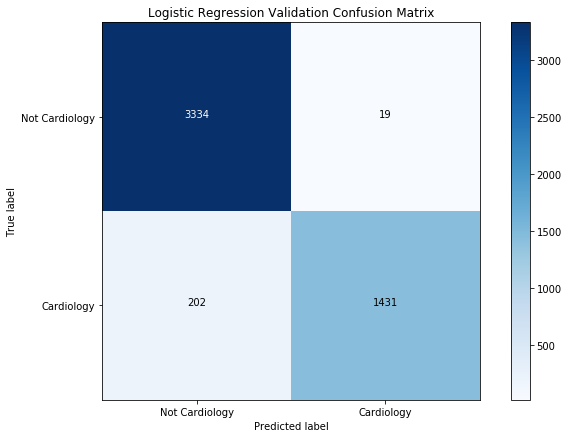

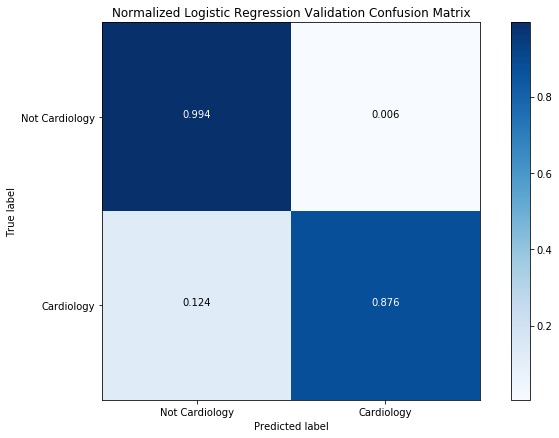

In [34]:
plot_confusion_matrix(confusion_matrix(df_valid['Cardiology'],lr_valid_pred),
   ["Not Cardiology","Cardiology"],normalize=False,
   title="Logistic Regression Validation Confusion Matrix")

plot_confusion_matrix(confusion_matrix(df_valid['Cardiology'],lr_valid_pred),
   ["Not Cardiology","Cardiology"],normalize=True,
   title="Normalized Logistic Regression Validation Confusion Matrix")

Next, examine the ROC and threshold plots.

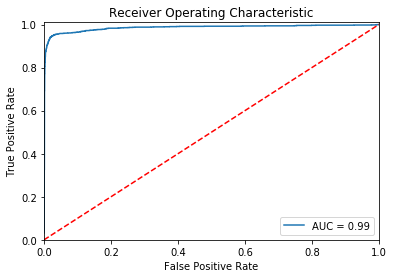

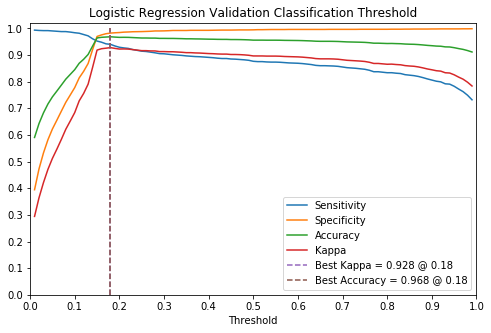

In [37]:
rocPlot(df_valid['Cardiology'],lr_valid_prob)

lr_kappa_threshold, lr_spec_threshold, lr_acc_threshold = findThresholds(df_valid['Cardiology'],lr_valid_prob,
      "Logistic Regression Validation")

The logistic regression performs fairly well so I'll try to improve the fit with a random forest classifier and repeat the diagnostics using the validation data.

In [38]:
from sklearn.ensemble import RandomForestClassifier

clfrf = RandomForestClassifier(max_features='auto',bootstrap=True,random_state=4783)
clfrf.fit(df_trainX,df_train['Cardiology'])

rf_valid_pred = clfrf.predict(df_validX)
rf_valid_prob = clfrf.predict_proba(df_validX)[:,1]

print(classification_report(df_valid['Cardiology'],rf_valid_pred))
print("Random forest validation accuracy = " + str(accuracy_score(df_valid['Cardiology'],rf_valid_pred)))

             precision    recall  f1-score   support

          0       0.97      0.99      0.98      3353
          1       0.98      0.93      0.95      1633

avg / total       0.97      0.97      0.97      4986

Random forest validation accuracy = 0.970517448856799


Examine the features ranked by importance. The top 30 should suffice. Note that the plot is rotated so the most important features will start at the bottom.

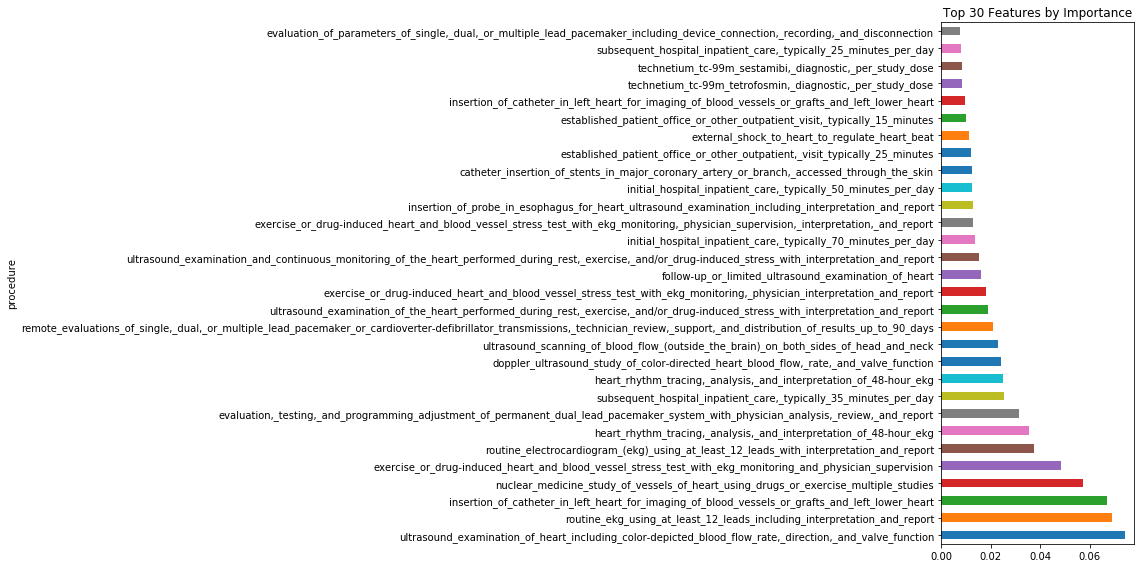

In [39]:
# extract the importance scores and use the lookup table to get the descriptions
rf_imp_features = pd.Series(clfrf.feature_importances_,
   index=df_trainX.columns).sort_values(ascending=False)
rf_imp_features = rf_imp_features.to_frame("Importance").join(proc_lookup,how='inner')

# plot the top 30 features by importance
rf_imp_features.head(30).plot(kind='barh',x='procedure',y='Importance',legend=False,
        title="Top 30 Features by Importance",figsize=(16,8))
plt.tight_layout()
plt.show()

Display the confusion matrix, counts and normalized, for the validation data.

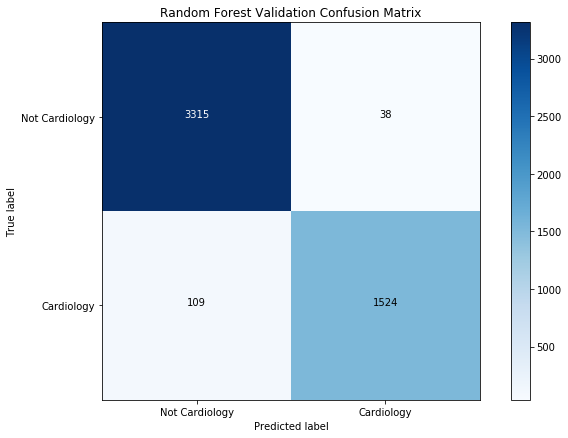

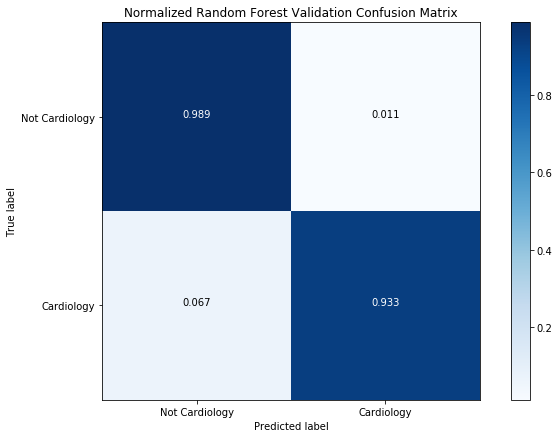

In [40]:
plot_confusion_matrix(confusion_matrix(df_valid['Cardiology'],rf_valid_pred),
   ["Not Cardiology","Cardiology"],normalize=False,
   title="Random Forest Validation Confusion Matrix")

plot_confusion_matrix(confusion_matrix(df_valid['Cardiology'],rf_valid_pred),
   ["Not Cardiology","Cardiology"],normalize=True,
   title="Normalized Random Forest Validation Confusion Matrix")

Next, examine the ROC and threshold plots.

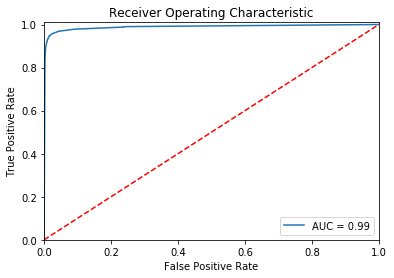

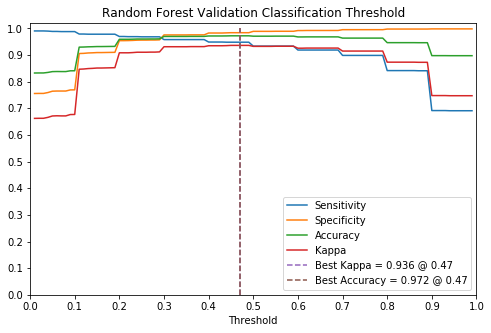

In [41]:
rocPlot(df_valid['Cardiology'],rf_valid_prob)

rf_kappa_threshold, rf_spec_threshold, rf_acc_threshold = findThresholds(df_valid['Cardiology'],rf_valid_prob,
   "Random Forest Validation")

The random forest is an improvement over the logistic regression. Next, try gradient boosting for the classifier. As before, the classification report and accuracy are reported for the validation data.

Note: This may run for several minutes.

In [42]:
from sklearn.ensemble import GradientBoostingClassifier

clfgb = GradientBoostingClassifier(loss='deviance',learning_rate=0.1,
      subsample=0.5,random_state=4783)
clfgb.fit(df_trainX,df_train['Cardiology'])

gb_valid_pred = clfgb.predict(df_validX)
gb_valid_prob = clfgb.predict_proba(df_validX)[:,1]

print(classification_report(df_valid['Cardiology'],gb_valid_pred))
print("Gradient boosting validation accuracy = " + str(accuracy_score(df_valid['Cardiology'],gb_valid_pred)))

             precision    recall  f1-score   support

          0       0.96      0.99      0.97      3353
          1       0.98      0.91      0.95      1633

avg / total       0.97      0.97      0.96      4986

Gradient boosting validation accuracy = 0.9653028479743281


Display the confusion matrix, counts and normalized, for the validation data.

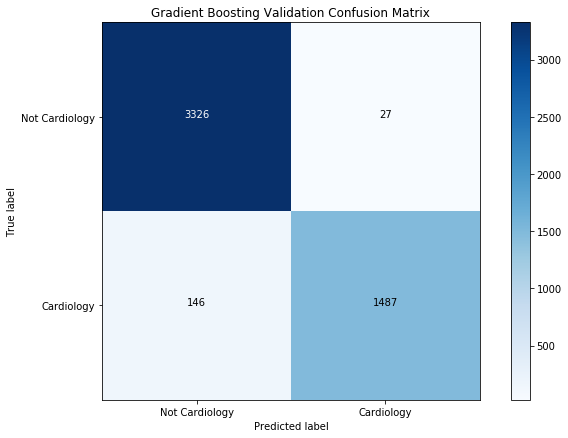

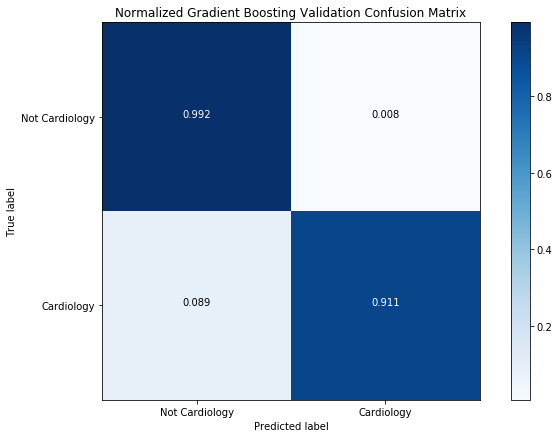

In [43]:
plot_confusion_matrix(confusion_matrix(df_valid['Cardiology'],gb_valid_pred),
   ["Not Cardiology","Cardiology"],normalize=False,
   title="Gradient Boosting Validation Confusion Matrix")

plot_confusion_matrix(confusion_matrix(df_valid['Cardiology'],gb_valid_pred),
   ["Not Cardiology","Cardiology"],normalize=True,
   title="Normalized Gradient Boosting Validation Confusion Matrix")

The ROC and threshold plots on the validation data.

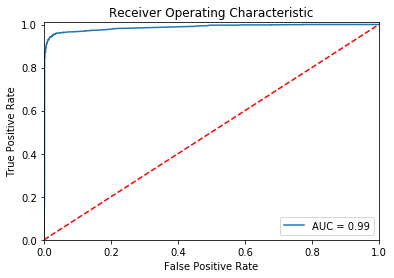

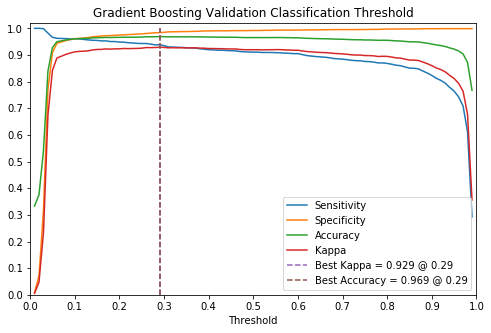

In [44]:
rocPlot(df_valid['Cardiology'],gb_valid_prob)

gb_kappa_threshold, gb_spec_threshold, gb_acc_threshold = findThresholds(df_valid['Cardiology'],gb_valid_prob,
   "Gradient Boosting Validation")

All 3 of the models are quite good, but the random forest has the highest accuracy and Cohen's kappa on the validation data. Now use cross-validation to search for the best number of estimators and tree depth and display the classification report and accuracy using the validation data.

Note: This may require 5-15 minutes to run.

In [45]:
param_grid = { 'n_estimators': [ 10, 25, 50, 75, 100, 125 ],
               'max_depth' : [ 3, 5, None ] }
grid_clfrf = GridSearchCV(clfrf, param_grid, scoring='accuracy', cv=10)
grid_clfrf.fit(df_trainX,df_train['Cardiology'])

# select the best estimator based on accuracy
best_clfrf = grid_clfrf.best_estimator_
brf_valid_pred = best_clfrf.predict(df_validX)
brf_valid_prob = best_clfrf.predict_proba(df_validX)[:,1]

print(classification_report(df_valid['Cardiology'],brf_valid_pred))
print("Random forest CV validation accuracy = " + str(accuracy_score(df_valid['Cardiology'],brf_valid_pred)))

             precision    recall  f1-score   support

          0       0.97      0.99      0.98      3353
          1       0.98      0.95      0.96      1633

avg / total       0.98      0.98      0.98      4986

Random forest CV validation accuracy = 0.9765342960288809


Display the features ranked by importance.

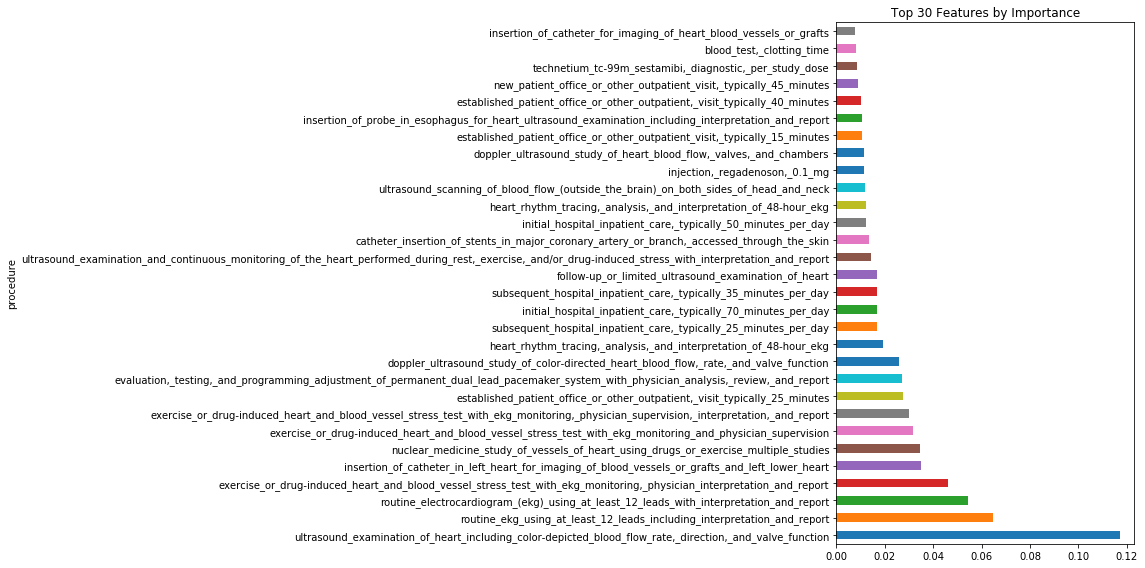

In [46]:
brf_imp_features = pd.Series(best_clfrf.feature_importances_, 
        index=df_trainX.columns).sort_values(ascending=False)
brf_imp_features = brf_imp_features.to_frame("Importance").join(proc_lookup,how='inner')

# plot the top 30 features by importance
brf_imp_features.head(30).plot(kind='barh',x='procedure',y='Importance',legend=False,
        title="Top 30 Features by Importance",figsize=(16,8))
plt.tight_layout()
plt.show()

Display the confusion matrix as well as threshold plot on the validation data in order to select the threshold for a prediction based on specificity. The **`test`** data will then be used to verify the fit and also examine the predictions based on the threshold for specificity.

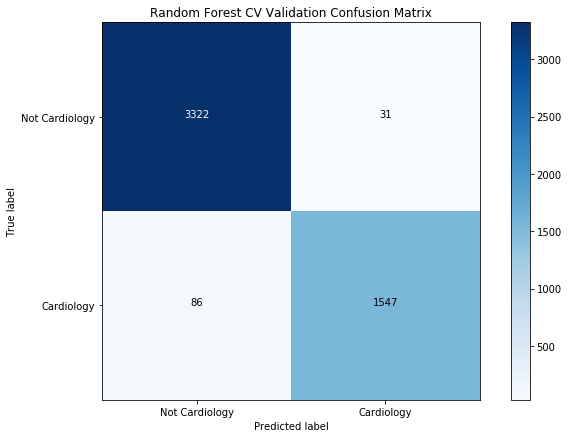

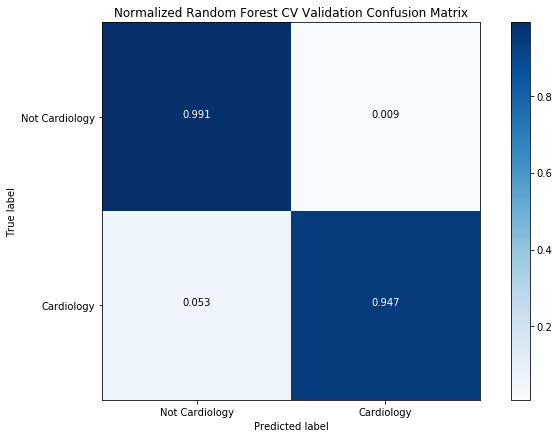

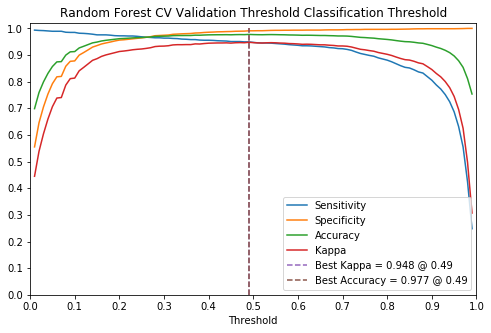

In [47]:
plot_confusion_matrix(confusion_matrix(df_valid['Cardiology'],brf_valid_pred),
   ["Not Cardiology","Cardiology"],normalize=False,
   title="Random Forest CV Validation Confusion Matrix")

plot_confusion_matrix(confusion_matrix(df_valid['Cardiology'],brf_valid_pred),
   ["Not Cardiology","Cardiology"],normalize=True,
   title="Normalized Random Forest CV Validation Confusion Matrix")

brf_kappa_threshold, brf_spec_threshold, brf_acc_threshold = findThresholds(df_valid['Cardiology'],brf_valid_prob,
   "Random Forest CV Validation Threshold")

Now it is time to use the **`test`** data to verify the tuned model.

In [48]:
brf_test_pred = best_clfrf.predict(df_testX)
brf_test_prob = best_clfrf.predict_proba(df_testX)[:,1]

# use the threshold from the validation data for the test predictions
brf_test_pred_spec = np.where(brf_test_prob >= brf_spec_threshold, 1, 0)

print(classification_report(df_test['Cardiology'],brf_test_pred))
print("Random forest CV test accuracy = " + str(accuracy_score(df_test['Cardiology'],brf_test_pred)))

             precision    recall  f1-score   support

          0       0.98      0.99      0.98      3341
          1       0.97      0.95      0.96      1645

avg / total       0.98      0.98      0.98      4986

Random forest CV test accuracy = 0.9763337344564781


The **`test`** accuracy is excellent. Now display the confusion matrix for the test predictions based on accuracy.

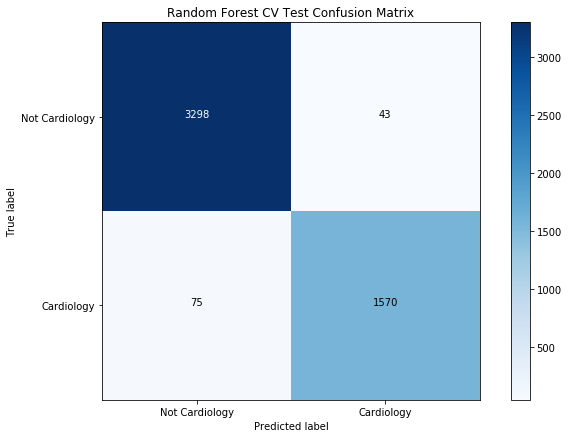

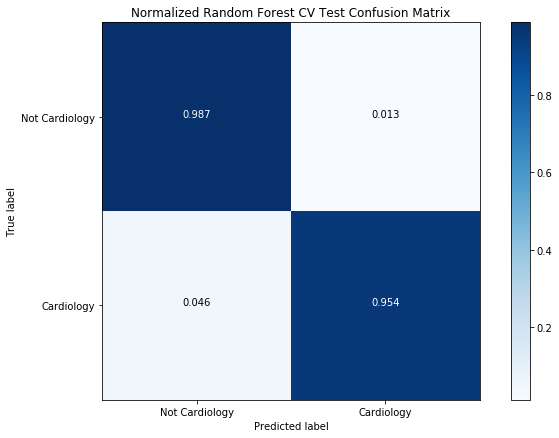

In [49]:
plot_confusion_matrix(confusion_matrix(df_test['Cardiology'],brf_test_pred),
   ["Not Cardiology","Cardiology"],normalize=False,
   title="Random Forest CV Test Confusion Matrix")

plot_confusion_matrix(confusion_matrix(df_test['Cardiology'],brf_test_pred),
   ["Not Cardiology","Cardiology"],normalize=True,
   title="Normalized Random Forest CV Test Confusion Matrix")

### Predict Cardiologists from the Unknowns

Generate a list of cardiologists, both known and predicted.

In [50]:
# predict cardiology for the unknown specialties. make 2 predictions, one based on
# accuracy and the other based on specificity. the latter should be used if the
# consequence of an incorrect prediction is very undesirable.
brf_unk_pred = best_clfrf.predict(df_unknownX)

# predicted cardiologists using threshold from best specificity
brf_unk_prob = best_clfrf.predict_proba(df_unknownX)[:,1]

# extract known cardilogists
df_card_known = df_codes.loc[(df_codes['Cardiology'] == 1),['physician_id']].reset_index(drop=True).copy()
df_card_known['Source'] = "Known"

# predicted cardiologists from accuracy
df_card_pred = pd.DataFrame(data={'physician_id':df_unknown['physician_id'],'pred':brf_unk_pred},index=None)
df_card_pred = df_card_pred.loc[(df_card_pred['pred'] == 1),['physician_id']].reset_index(drop=True).copy()
df_card_pred['Source'] = "Predicted"

df_cardiologists = df_card_known.append(df_card_pred).copy()

Display frequency table.

In [51]:
display(HTML("<h4>Cardiologists, Known and Predicted</h4>"))
display(HTML(pd.crosstab(df_cardiologists['Source'],columns='count').to_html()))

col_0,count
Source,
Known,8274
Predicted,3630


Export the cardiologists, **`df_cardiologists`** to **`cardiologists.csv`**.

In [52]:
df_cardiologists.to_csv("cardiologists.csv",index=False,header=True)

### Summary

Building a classification model to identify cardiologists worked very well. There were a large number of known cardiologists and patient counts. Most of the specialties in the data are under-represented. For example, the median number of physicians in this data for a specialty is 50. The 75<sup>th</sup> percentile is 285. That is still low, but may be workable using case-control sampling if the population percentage for the specialty is known.

Here is a plot of the most represented specialties (excluding cardiology and unknown).

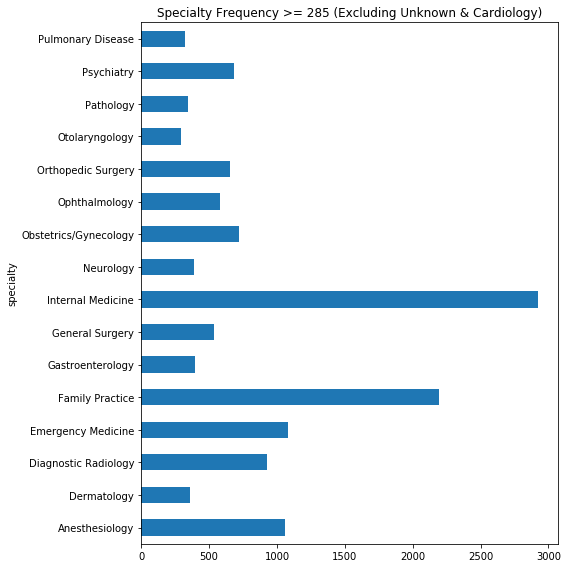

In [53]:
q75 = specialties.quantile(q=0.75)[0]
specialties[(specialties['count'] >= q75) & 
            (specialties.index.str.startswith("Unknown") == False) &
            (specialties.index != "Cardiology")].plot.barh(legend=False,
            title="Specialty Frequency >= %0.f (Excluding Unknown & Cardiology)" % q75,figsize=(8,8))
plt.tight_layout()
plt.show()

The procedure codes for Internal Medicine and Family Practice will be similar so identifying these specialties will be difficult. This can be checked in the same manner as the check performed on Cardiology and Unknown earlier in this notebook. If so, then this approach is applicable. For the remaining specialties, if we focus only on those with a large number of physicians then this approach, or a multinomial classification, could be utilized.